# Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device {device}")

Working on device cuda


# Load dataset

In [2]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('dataset', download=False, train=True, transform=transform)
valset_full = datasets.MNIST('dataset', download=False, train=False, transform=transform)

val_size, test_size = 1000, 9000
val_dataset, test_dataset = torch.utils.data.random_split(valset_full, [val_size, test_size], generator=torch.Generator().manual_seed(27))

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False) 

# Models

In [13]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        out = torch.nn.functional.tanh(self.dense1(X))
        out = torch.transpose(out, -1, -2)
        out = torch.nn.functional.tanh(self.dense2(out))
        out = torch.transpose(out, -2, -1)
        return out
    
class PFNN_2l_sq(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(PFNN_2l_sq, self).__init__()
        
        self.PFFN1 = PositionWiseFFN(input_size,input_size)
        self.PFFN2 = PositionWiseFFN(input_size,input_size)
        
        dropout = 0.03
        self.dropout = nn.Dropout(dropout)
        
        # self.BN1 = nn.LayerNorm((1,input_size,input_size))
        
        self.W_o = nn.LazyLinear( num_classes, device=device)
        
        self.num_classes = num_classes

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        out = self.PFFN1(x)
        out = self.PFFN2(out)
        
        out = out.reshape(out.shape[0],-1)
        
        out = self.log_softmax(self.dropout(self.W_o(out)))
        
        return out
    
    def get_embeddings(self,x):
        e1 = self.PFFN1(x)
        e2 = self.PFFN2(e1)        
        
        return e1,e2

# Train loop

In [10]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

N_epoch = 150
model = PFNN_2l_sq(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\pffn_28-28_epoch_{N_epoch}.pth')) #, map_location=torch.device('cpu')
# print(model)
model.to(device)

# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
criterion = nn.NLLLoss()  # Use CrossEntropyLoss which includes softmax
optimizer = optim.Adam(model.parameters(), lr=50e-4, weight_decay=25e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.96, verbose=False)

# Track loss
loss_list = []
val_loss_list = []

# Training the network
epochs = 300
time0 = time()

for epoch in range(epochs):
    running_loss = 0

    # for images, labels in tqdm(trainloader, leave=False):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.squeeze(1)                 

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)               
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
    
    # validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.squeeze(1)                 
            
            output = model(images)
            val_loss = criterion(output, labels)
    val_loss = val_loss / len(val_loader)
    val_loss_list.append(val_loss)
        
    CE_curr = running_loss / len(trainloader)
    loss_list.append(CE_curr)
    # if (epoch%10)==0:
    print(f"Epoch {epoch} - Training loss: {CE_curr:.5f}, Val loss: {val_loss:.5f}")
    
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60:.2f}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)

val_loss = [val.cpu().numpy() for val in val_loss_list]

val_loss_array = np.array(val_loss)

# Save the model
torch.save(model.state_dict(), f'model_backup\pffn_28-28_epoch_{N_epoch+epochs}.pth')

c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0 - Training loss: 0.07882, Val loss: 0.08619
Epoch 1 - Training loss: 0.04356, Val loss: 0.07514
Epoch 2 - Training loss: 0.04003, Val loss: 0.08260
Epoch 3 - Training loss: 0.03894, Val loss: 0.08164
Epoch 4 - Training loss: 0.03698, Val loss: 0.07609
Epoch 5 - Training loss: 0.03640, Val loss: 0.07635
Epoch 6 - Training loss: 0.03521, Val loss: 0.07701
Epoch 7 - Training loss: 0.03423, Val loss: 0.07663
Epoch 8 - Training loss: 0.03358, Val loss: 0.07550
Epoch 9 - Training loss: 0.03285, Val loss: 0.07518
Epoch 10 - Training loss: 0.03222, Val loss: 0.07584
Epoch 11 - Training loss: 0.03162, Val loss: 0.07478
Epoch 12 - Training loss: 0.03067, Val loss: 0.07278
Epoch 13 - Training loss: 0.03046, Val loss: 0.07672
Epoch 14 - Training loss: 0.03024, Val loss: 0.07514
Epoch 15 - Training loss: 0.02974, Val loss: 0.07493
Epoch 16 - Training loss: 0.02924, Val loss: 0.07330
Epoch 17 - Training loss: 0.02918, Val loss: 0.07428
Epoch 18 - Training loss: 0.02889, Val loss: 0.07329
Epo

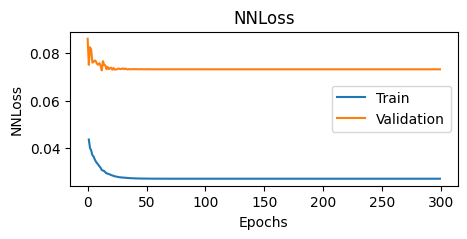

In [11]:
# epochs = 30
# N_epoch = 0
# # Save the model
# torch.save(model.state_dict(), f'model_backup\SDPA_2H_seq_d{d1}-d{d2}_pffn_epoch_{N_epoch+epochs}.pth')

# Plot NLL_loss
plt.figure(figsize=(5, 2))
plt.plot(range(len(loss_array))[1:], loss_array[1:], label='Train')
plt.plot(range(len(val_loss_array)), val_loss_array, label='Validation')

plt.xlabel('Epochs')
plt.ylabel('NNLoss')
plt.title('NNLoss')
plt.legend()
plt.show()

# NN test

In [ ]:
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = PFNN_2l_sq(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\pffn_28-28_epoch_{N_epoch+epochs}.pth')) # , map_location=torch.device('cpu')

model.to(device)

correct = 0
total = 0

model.eval()
for X, y_true in test_loader:
    X = X.squeeze(1) 
    X = X.to(device)
    y_true = y_true.to(device)
    
    outputs = model(X)
    _,y_pred = torch.max(outputs, dim=1)
    total +=y_true.shape[0]
    correct +=int((y_pred==y_true).sum())

print(f"Accuracy = {correct/total: .4f}")

Accuracy =  0.9834


# Visualization

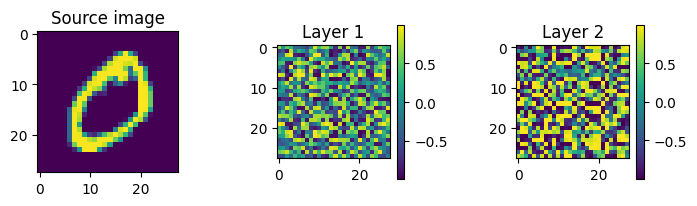

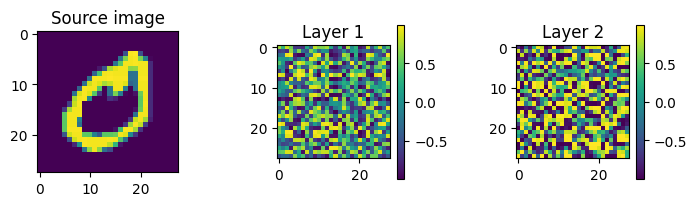

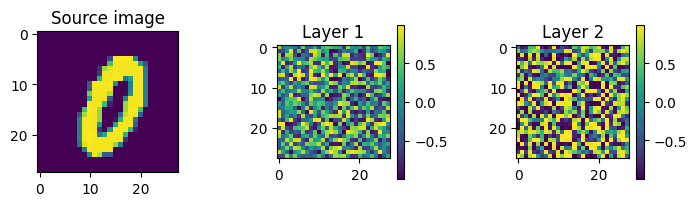

In [41]:
model = PFNN_2l_sq(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\pffn_28-28_epoch_{N_epoch+epochs}.pth')) # , map_location=torch.device('cpu')
model = model.to(device)

for i in [1,21,34]:
    img, label = trainset[i]
    img = img.to(device)

    e1,e2 = model.get_embeddings(img)

    fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=3)
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze(0).detach().cpu())
    plt.title('Source image')
    plt.subplot(1,3,2)
    plt.imshow(e1.squeeze(0).detach().cpu())
    plt.title('Layer 1')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(e2.squeeze(0).detach().cpu())
    plt.title('Layer 2')
    plt.colorbar()
    

    plt.subplots_adjust(wspace=0.7)

In [45]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

11098
